In [1]:
from pathlib import Path
import sys

from arcgis.geometry import Geometry
import arcpy
import pandas as pd

project_parent = Path('./').absolute().parent.parent

# import the project package from the project package path
# ideally will be imported using 'from arcgis import dm'
sys.path.append(str(project_parent/'src'))
import dm
from dm._modify_geoaccessor import GeoAccessorIO as GeoAccessor

# load the "autoreload" extension so as src code is changed, the changes are picked up in the dataframe
%load_ext autoreload
%autoreload 2

D:\projects\demographic-modeling-module\src\dm\_modify_geoaccessor.py:31: UserWarning: registration of accessor <class 'dm._modify_geoaccessor.GeoAccessorIO'> under name 'spatial' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexistingattribute with the same name.
  class GeoAccessorIO(GeoAccessor):


In [2]:
usa = dm.Country('USA')

In [3]:
tract_df = usa.cbsas.get('minneapolis').census_tracts.get()

tract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      789 non-null    object  
 1   NAME    789 non-null    object  
 2   SHAPE   789 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 18.6+ KB


In [4]:
tract_df.spatial.plot()

MapView(layout=Layout(height='400px', width='100%'))

In [5]:
tract_df.head()

,ID,NAME,SHAPE
0,27079950400,270799504.00,"{""rings"": [[[-10415955.3616, 5511892.221699998..."
1,27079950500,270799505.00,"{""rings"": [[[-10431098.4859, 5528517.864500001..."
2,27079950600,270799506.00,"{""rings"": [[[-10456149.8241, 5523972.706100002..."
3,27143170200,271431702.00,"{""rings"": [[[-10519477.4972, 5577105.204499997..."
4,27019090301,270190903.01,"{""rings"": [[[-10448941.887, 5604401.5282000005..."


In [9]:
bp_pth = Path(r'D:\arcgis\ba_data\Data\Demographic Data\block_data.gdb\USA_ESRI_2019_blocks')

In [10]:
bp_df = GeoAccessor.from_featureclass(bp_pth, fields=['FIPS', 'POP_C', 'HH_C', 'HU_C'])
bp_df.spatial.project(4326)
bp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6901541 entries, 0 to 6901540
Data columns (total 5 columns):
 #   Column  Dtype   
---  ------  -----   
 0   FIPS    object  
 1   POP_C   float64 
 2   HH_C    float64 
 3   HU_C    float64 
 4   SHAPE   geometry
dtypes: float64(3), geometry(1), object(1)
memory usage: 263.3+ MB


In [11]:
bp_df.head()

,FIPS,POP_C,HH_C,HU_C,SHAPE
0,150039812001004,0.0,0.0,0.0,"{""x"": -166.28822369728738, ""y"": 23.86846842713..."
1,150039812001005,0.0,0.0,0.0,"{""x"": -166.21047832818513, ""y"": 23.78768193935..."
2,150039812001006,0.0,0.0,0.0,"{""x"": -166.24250323482633, ""y"": 23.87162798684..."
3,150039812001007,0.0,0.0,0.0,"{""x"": -166.2416286117095, ""y"": 23.871505564170..."
4,150039812001008,0.0,0.0,0.0,"{""x"": -166.2871994031661, ""y"": 23.868746072686..."


In [26]:
bp_id = bp_df.iloc[0].FIPS

In [27]:
poly_id = tract_df.iloc[0].ID

In [34]:
bp_df['poly_id'] = bp_df.FIPS.str[:len(poly_id) - len(bp_id)]

In [35]:
bp_df.head()

,FIPS,POP_C,HH_C,HU_C,SHAPE,poly_id
0,150039812001004,0.0,0.0,0.0,"{""x"": -18511120.3869, ""y"": 2737388.585900001, ...",15003981200
1,150039812001005,0.0,0.0,0.0,"{""x"": -18502465.812, ""y"": 2727557.4893999994, ...",15003981200
2,150039812001006,0.0,0.0,0.0,"{""x"": -18506030.8083, ""y"": 2737773.204599999, ...",15003981200
3,150039812001007,0.0,0.0,0.0,"{""x"": -18505933.4457, ""y"": 2737758.3016999997,...",15003981200
4,150039812001008,0.0,0.0,0.0,"{""x"": -18511006.362999998, ""y"": 2737422.3838, ...",15003981200


In [ ]:
wgt_col = 'HH_C'

# multiply the weight by the respecgive coordinate columns
bp_df['w_x'] = bp_df[wgt_col] * bp_df['SHAPE'].apply(lambda geom: geom.centroid[0])
bp_df['w_y'] = bp_df[wgt_col] * bp_df['SHAPE'].apply(lambda geom: geom.centroid[1])

bp_df.head()

In [91]:
# get the sum of the weight column multiplied by the respective coordiante values along with the sum of the 
# weighting column when grouped by the containing polygon id 
wgt_df = bp_df[['poly_id', 'w_x', 'w_y', wgt_col]].groupby('poly_id').sum()

wgt_df.head()

,w_x,w_y,HH_C
poly_id,,,
01001020100,-6.671975e+09,2.651365e+09,693.0
01001020200,-7.152172e+09,2.842263e+09,743.0
01001020300,-1.208854e+10,4.805020e+09,1256.0
01001020400,-1.657047e+10,6.586550e+09,1722.0
01001020500,-3.927138e+10,1.561182e+10,4082.0


In [92]:
# divide the sum of weight multiplied by each respetive coordinate by the sum of the weight to get mean coordinates by polygon id
wgt_df['x'] = wgt_df['w_x'] / wgt_df[wgt_col]
wgt_df['y'] = wgt_df['w_y'] / wgt_df[wgt_col]

wgt_df.head()

,w_x,w_y,HH_C,x,y
poly_id,,,,,
01001020100,-6.671975e+09,2.651365e+09,693.0,-9.627669e+06,3.825924e+06
01001020200,-7.152172e+09,2.842263e+09,743.0,-9.626073e+06,3.825387e+06
01001020300,-1.208854e+10,4.805020e+09,1256.0,-9.624632e+06,3.825653e+06
01001020400,-1.657047e+10,6.586550e+09,1722.0,-9.622804e+06,3.824942e+06
01001020500,-3.927138e+10,1.561182e+10,4082.0,-9.620623e+06,3.824551e+06


In [93]:
from arcgis.geometry import Geometry

spatial_reference = bp_df.iloc[0].SHAPE.spatial_reference

wgt_df['SHAPE'] = wgt_df[['x', 'y']].apply(lambda r: Geometry({'x': r[0], 'y': r[1], 'spatial_reference': spatial_reference}))

wgt_df.spatial.set_geometry('SHAPE')

wgt_df.spatial.validate()

True

In [94]:
wgt_df.head()

,w_x,w_y,HH_C,x,y,SHAPE
poly_id,,,,,,
01001020100,-6.671975e+09,2.651365e+09,693.0,-9.627669e+06,3.825924e+06,None
01001020200,-7.152172e+09,2.842263e+09,743.0,-9.626073e+06,3.825387e+06,None
01001020300,-1.208854e+10,4.805020e+09,1256.0,-9.624632e+06,3.825653e+06,None
01001020400,-1.657047e+10,6.586550e+09,1722.0,-9.622804e+06,3.824942e+06,None
01001020500,-3.927138e+10,1.561182e+10,4082.0,-9.620623e+06,3.824551e+06,None


In [57]:
r = wgt_df.iloc[0][['x', 'y']]

In [58]:
r

x   -9.62766e+06
y    3.82595e+06
Name: 01001020100, dtype: object

C:\Program Files\ArcGIS\Pro\Resources\ArcPy\arcpy\geoprocessing\_base.py:482: RuntimeWarning: No spatial reference detected, defaulting to unknown coordinate system.
  return self._gp.FromEsriJson(json)


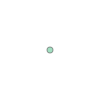

In [74]:
Geometry({'x': r[0], 'y': r[1], 'spatial_reference': {'wkid': spatial_reference.wkid, 'latestWkid': spatial_reference.latestWkid}})

In [73]:
spatial_reference.wkid, spatial_reference.latestWkid

(102100, 3857)

In [67]:
r[1]

3825953.093143097

In [83]:
bp_df[bp_df.poly_id.isin(wgt_df[wgt_df.x.isnull()].index)]

,FIPS,POP_C,HH_C,HU_C,SHAPE,poly_id,w_x,w_y
0,150039812001004,0.0,0.0,0.0,"{""x"": -18511120.3869, ""y"": 2737388.585900001, ...",15003981200,-0.0,0.0
1,150039812001005,0.0,0.0,0.0,"{""x"": -18502465.812, ""y"": 2727557.4893999994, ...",15003981200,-0.0,0.0
2,150039812001006,0.0,0.0,0.0,"{""x"": -18506030.8083, ""y"": 2737773.204599999, ...",15003981200,-0.0,0.0
3,150039812001007,0.0,0.0,0.0,"{""x"": -18505933.4457, ""y"": 2737758.3016999997,...",15003981200,-0.0,0.0
4,150039812001008,0.0,0.0,0.0,"{""x"": -18511006.362999998, ""y"": 2737422.3838, ...",15003981200,-0.0,0.0
...,...,...,...,...,...,...,...,...
6792311,330159800111031,0.0,0.0,0.0,"{""x"": -7952967.856899999, ""y"": 5299795.8487000...",33015980011,-0.0,0.0
6792312,330159800111032,0.0,0.0,0.0,"{""x"": -7953522.862500001, ""y"": 5300894.4301000...",33015980011,-0.0,0.0
6792313,330159800111033,0.0,0.0,0.0,"{""x"": -7951603.180199999, ""y"": 5299054.7421, ""...",33015980011,-0.0,0.0
6792314,330159800111034,0.0,0.0,0.0,"{""x"": -7951023.361500001, ""y"": 5298949.5584999...",33015980011,-0.0,0.0
